
# Übung 5: Hough-Transformation 

In dieser Uebung implementieren wir die Hough-Transformation fuer Geraden (HoughLines),
analog zum vorgegebenen Pseudocode. Der Code ist moduliert in:
1. HoughLines-Funktion (Aufbau von Acc, Center-Verschiebung, Aufruf Acc-Fuellung)
2. fillHoughAccumulator (Schleife ueber Bildkoordinaten)
3. doPixel (Berechnung von rho fuer jedes theta und Inkrement)

(-0.5, 378.025, 239.5, -155.68435204919078)

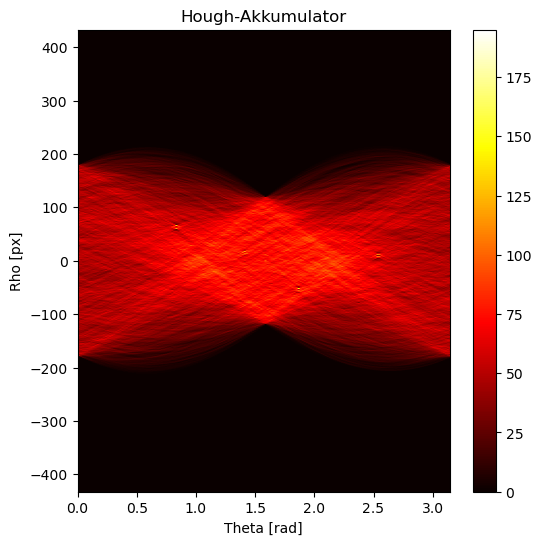

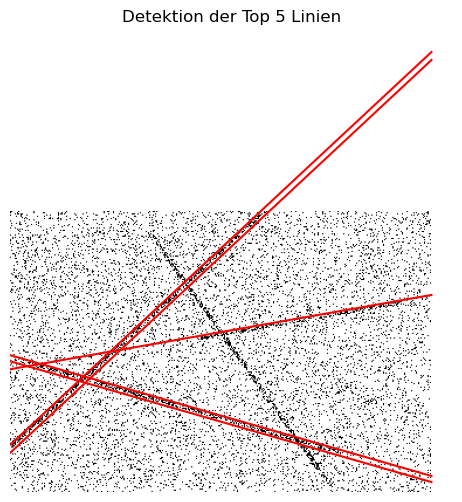

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature
from scipy.ndimage import maximum_filter



def HoughLines(image_edge, num_theta=180, num_rho=None):
    """
    Implementierung der Hough-Linien-Transformation nach Pseudocode.
    :param image_edge: Binärbild mit Kantenpunkten (0/1)
    :param num_theta: Anzahl Theta-Bins
    :param num_rho: Anzahl Rho-Bins (falls None, wird basierend auf Bildabschnitt berechnet)
    :return: accumulator (num_rho x num_theta), thetas, rhos
    """
    # Bilddimensionen
    ny, nx = image_edge.shape
    # Mittelpunkt des Bildes
    uc, vc = nx/2.0, ny/2.0
    # Theta-Vektor [0, pi)
    thetas = np.linspace(0, np.pi, num_theta, endpoint=False)
    # Maximaler Abstand (Diagonale)
    diag_len = np.hypot(nx, ny)
    if num_rho is None:
        num_rho = int(2*diag_len)
    # Rho-Vektor von -diag_len bis diag_len
    rhos = np.linspace(-diag_len, diag_len, num_rho)
    # Akkumulator initialisieren
    accumulator = np.zeros((num_rho, num_theta), dtype=int)
    # Precompute cos und sin
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    # Fuellung des Akkumulators
    fillHoughAccumulator(image_edge, accumulator, uc, vc, rhos, cos_t, sin_t)
    return accumulator, thetas, rhos


# Füllfunktion
# Füllt den Akkumulator gemäss Pseudocode: Schleife ueber alle Pixel und doPixel-Aufruf
def fillHoughAccumulator(image_edge, accumulator, uc, vc, rhos, cos_t, sin_t):
    ny, nx = image_edge.shape
    num_rho, num_theta = accumulator.shape
    # Schleife ueber alle Bildkoordinaten
    for v in range(ny):
        for u in range(nx):
            if image_edge[v, u]:
                doPixel(u, v, accumulator, uc, vc, rhos, cos_t, sin_t)


# doPixel-Funktion
# Berechnet fuer jeden Theta den entsprechenden Rho, findet den naechsten Index und erhoeht Acc.
def doPixel(u, v, accumulator, uc, vc, rhos, cos_t, sin_t):
    # Verschieben zum Bildzentrum
    x = u - uc
    y = v - vc
    num_rho, num_theta = accumulator.shape
    # Fuer jedes Theta den Rho-Wert berechnen und Akkumulator erhoehen
    for t_idx in range(num_theta):
        rho_val = x * cos_t[t_idx] + y * sin_t[t_idx]
        # Index des naechstliegenden Rho
        # np.searchsorted ist schneller als abs-argmin
        r_idx = np.searchsorted(rhos, rho_val)
        if 0 <= r_idx < num_rho:
            accumulator[r_idx, t_idx] += 1

# Anwendung auf "noisy-lines"
# Bild laden und Canny-Kantendetektion
image = io.imread('noisy-lines.tif', as_gray=True)
edges = feature.canny(image, sigma=2)

# HoughLines aufrufen
acc, thetas, rhos = HoughLines(edges.astype(int), num_theta=180)

# Darstellung des Hough-Akkumulators
plt.figure(figsize=(6,6))
plt.imshow(acc, extent=[0, np.pi, -rhos.max(), rhos.max()], aspect='auto', cmap='hot')
plt.xlabel('Theta [rad]')
plt.ylabel('Rho [px]')
plt.title('Hough-Akkumulator')
plt.colorbar()

# ## Thresholding und Visualisierung der Top-K-Kanten
K = 5  # Anzahl staerkste Linien
threshold = int(0.5 * acc.max())
# einfache Peak-Suche: lokales Maximum + Threshold
neighborhood = maximum_filter(acc, size=5)
peaks = (acc == neighborhood) & (acc > threshold)
coords = np.argwhere(peaks)
# Top-K Waehlen
values = [acc[tuple(coord)] for coord in coords]
sorted_idx = np.argsort(values)[::-1][:K]
top_coords = coords[sorted_idx]

# %%
# Linien ins Bild zeichnen 
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
ny, nx = image.shape
uc, vc = nx/2.0, ny/2.0
for rho_idx, theta_idx in top_coords:
    rho = rhos[rho_idx]
    theta = thetas[theta_idx]
    # Bildkoordinaten u in [0, nx]
    u_vals = np.array([0, nx])
    # Rücktransformation: (u-uc)*cos + (v-vc)*sin = rho  =>  v = ((rho - (u-uc)*cos)/sin) + vc
    if np.sin(theta) != 0:
        v_vals = (rho - (u_vals - uc) * np.cos(theta)) / np.sin(theta) + vc
        plt.plot(u_vals, v_vals, '-r')
plt.title(f'Detektion der Top {K} Linien')
plt.axis('off')


**Hough Akkumulato - Legende:**

- x-Achse (Theta [rad]): Winkel der Geraden zwischen 0 und π.

- y-Achse (Rho [px]): Abstand der Geraden vom Bildzentrum.

- Farbe: Anzahl der Kantenpunkte, die genau diese (θ, ρ)-Kombination unterstützen.


## Zusammenfassung
Wir haben den Programmansatz gemäss Pseudocode umgesetzt mit modularen Funktionen:
- HoughLines: zentraler Aufruf, Aufbau von Acc und Aufruf der Fuell-Funktionen
- fillHoughAccumulator: Schleife ueber alle Kantenpunkte
- doPixel: Berechnung und Inkrement im Akkumulator
Anschliessend Visualisierung und Auswahl der staerksten Kanten mittels lokaler Maxima.



### Aufgabe 4: Fragen beantworten
**a)** Mit der Schwellenoperation wählt man im Hough-Akkumulator alle Einträge (θ, ρ) aus, deren Akkumulatorwert über dem gewählten Schwellenwert liegt. Jeder ausgewählte Peak steht für eine Gerade, die von vielen Kantenpunkten im ursprünglichen Bild unterstützt wird. Durch Rückprojektion dieser Parameter (θ, ρ) auf das Ausgangsbild erhält man die detektierten Kantenlinien.

**b)** Die dominierendsten (längsten) Kanten entsprechen den höchsten Peaks im Akkumulator nach Thresholding. Im Code sortieren wir die gefilterten Peaks nach ihren Akkumulatorwerten und wählen die Top K–Werte (hier K = 5) aus. Das sind jene Geraden mit den meisten Stimmen (d.h. mit den meisten Kantenpunkten auf der Linie).
 
**c)** Bei der **Non-Maximum Suppression** wird das Akkumulator-Array zunächst mit einem Maximum-Filter (z.B. 5×5 Fenster) verarbeitet. Ein Eintrag gilt nur dann als gültiger Peak, wenn
1. sein Wert gleich dem lokalen Maximum in seiner Umgebung ist, und
2. er den Schwellenwert überschreitet.

Dadurch werden Nebenspitzen unterdrückt, und nur wirklich dominante, lokal isolierte Peaks bleiben übrig, was zu präziseren Linienparametern führt.
